In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import numpy as np
import urllib.request 
import glob
from collections import OrderedDict

First, let's retrieve the contour plot values from hepdata.  We're pulling this down as a CSV file, and probably you could use a 'real' python csv reader for this, or pull the data as JSON or YAML and use that instead.  But this should work too:

In [2]:
contour_mass=[]
contour_splitting=[]
# Higgsinos: 14a
# Sleptons: 16a
with urllib.request.urlopen('https://www.hepdata.net/download/table/ins1767649/Figure%2014a%20Expected/4/csv') as response:
    for line in response:
        sline=line.decode("utf-8") 
        if sline[0]=='#' or sline[0]=='$': continue
        if len(sline.strip())==0: continue
        contour_mass.append(float(sline.split(',')[0]))
        contour_splitting.append(float(sline.split(',')[1]))

Here are the values that we got from running the reinterpretation pipeline, taken from log files:

In [3]:
masses=[100,125,150,175,200,225,250]
splittings=[1.5,2,3,5,10,15,20,25,30,40,60]

expecteddict={}
observeddict={}

for m in masses:
    expecteddict[m]={}
    observeddict[m]={}
    for dM in splittings:
        mN1=m-dM
        dirname=f"/data/users/mhance/SUSY/SUSY_Higgsino_isr2L_grid_20220811/SUSY_Higgsino_isr2L_{m}_{mN1}"
        filename=f"{dirname}/logs/docker_muscan.log"
        with open(filename,'r') as f:
            for line in f:
                if "Expected limit" in line:
                    expecteddict[m][dM]=float(line.split()[-1])
                elif "Observed limit" in line:
                    observeddict[m][dM]=float(line.split()[-1])

#print(expecteddict)                    
expecteddata=list(list(f.values()) for f in list(expecteddict.values()))
#print(expecteddata)

It's not obvious from the arrays above, but when we enter the data like that, it's actually transposed relative to the 'normal' presentation, where mass is on the x-axis and mass splitting is on the y-axis.  This command will transpose the data.

In [4]:
expecteddata=np.array(expecteddata).T.tolist()

This is the 'canvas' we'll use to draw the plots.  Make the y-axis on a log scale.

I'm not as familiar with seaborn libraries, but I know that pcolormesh can handle non-uniform spacing in x and in y.  Also, we need to make sure that the expected limits above are drawn at the right x,y values so the contours can be overlaid...  if we don't specify x and y values (here, mass and mass splitting) then the heatmap will just be drawn at values of 0,1,2,...,7 or something, while the contour will be drawn at values closer to 100, and they won't overlap correctly.

To get the plots to overlay, use the 'ax' object to draw the plots.

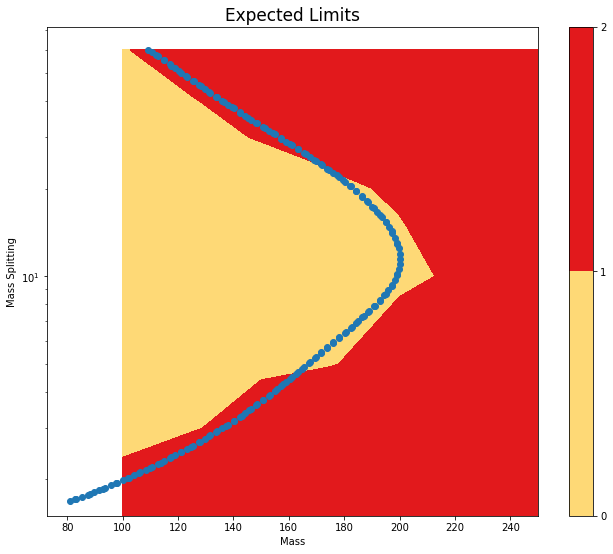

In [5]:
fig, ax = plt.subplots(figsize=(11,9))
ax.set_yscale('log')

## I'm sure this can work, but I'm not sure how to fix it as is:
#plot2 = sb.heatmap(expecteddata, xticklabels = False, yticklabels = False, cmap = 'YlOrRd', annot = True)
#plt.yticks([7,6,5,4,3,2,1,0], ['0.5','1','2','5','10', '15', '20', '30'])
#plt.xticks([0,1,2,3,4,5], ['100', '125', '150', '200', '250', '300'])

## I might do this instead:
#heatmap=ax.pcolormesh(masses,splittings,expecteddata,cmap='YlOrRd',shading='auto') # shading='gouraud' will smooth this out
## show the z-axis scales
#fig.colorbar(heatmap, ax=ax)

# this seems even better:
# control where the colors change with this array:
levels=[0,1,2]
# then draw the heatmap, which does some interpolation
heatmap=ax.contourf(masses,splittings,expecteddata,levels,cmap='YlOrRd')
fig.colorbar(heatmap, ax=ax)

# now overlay the contour by drawing it on the same axis:
contour=ax.scatter(contour_mass,contour_splitting)

# formatting:
plt.xlabel('Mass')
plt.ylabel('Mass Splitting')
plt.title('Expected Limits', size = 17)

# done!
plt.show()

Now show the boundary at mu=1 as a contour instead of a heatmap

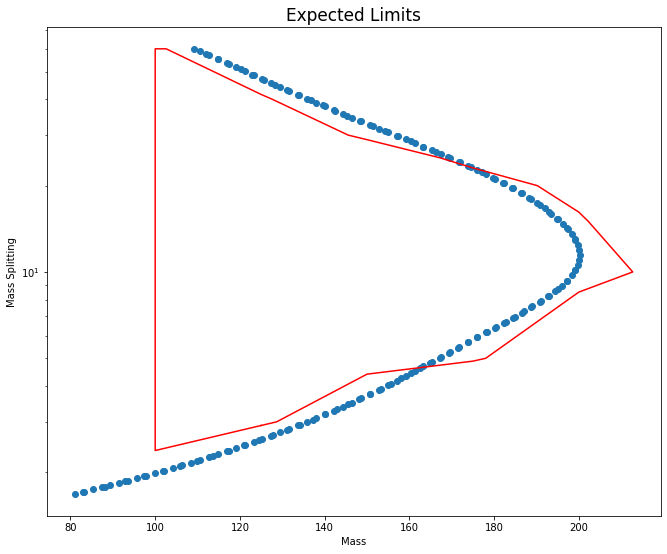

In [6]:
fig, ax = plt.subplots(figsize=(11,9))
ax.set_yscale('log')

# 
contourpath=heatmap.collections[0].get_paths()[0]
vertices=contourpath.vertices
contour_x=vertices[:,0]
contour_y=vertices[:,1]
contour=ax.plot(contour_x,contour_y,color="red")

# now overlay the contour by drawing it on the same axis:
contour=ax.scatter(contour_mass,contour_splitting)

plt.xlabel('Mass')
plt.ylabel('Mass Splitting')
plt.title('Expected Limits', size = 17)
plt.show()

code it up a bit better

Missing output for m=250 and dM=20, setting to 2.0


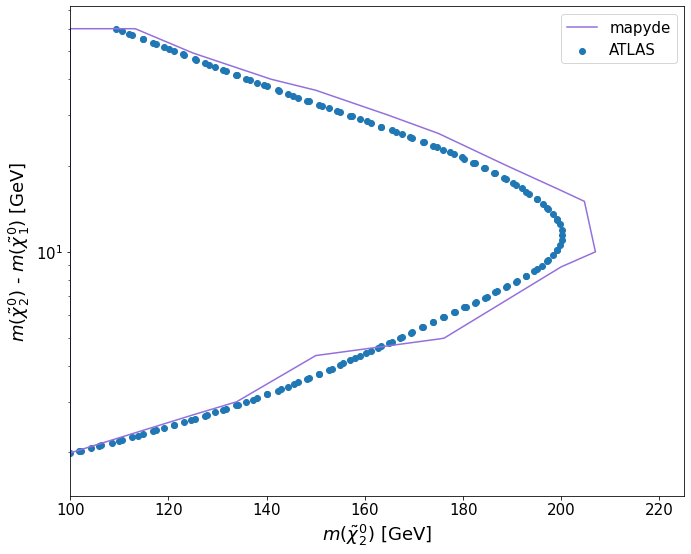

<Figure size 792x648 with 0 Axes>

In [9]:
def makecontour(basepath="/data/users/mhance/SUSY/SUSY_Higgsino_isr2L_grid_20220811",label=""):
    masses=[]
    splittings=[]
    masses=[100,125,150,175,200,225,250]
    splittings=[1.5,2,3,5,10,15,20,30,40,60]

    colors["10"]="orange"    # 10k
    colors["11"]="red"       # 50k
    colors["14"]="yellow"    # do not use
    colors["15"]="green"     # w/o subtracting muons
    colors["17"]="black"     # w/ stable C1's and bad decay strings
    colors["22"]="gray"      # madspin with better C1's, C1C1 still off
    colors["23"]="cyan"      # 10k events per point, with C1C1
    colors["24"]="magenta"   # 20k events per point, no C1C1
    colors["24_noMPI"]="teal" # no MPI
    colors["24_delphes_leptoneff_001"]="olivedrab"
    colors["25"]="tan"
    colors["06"]="mediumpurple"
    
    expecteddict={}
    observeddict={}

    for m in masses:
        for dM in splittings:
            mN1=m-dM
            mN2=m
                
            if mN2 not in expecteddict:
                expecteddict[mN2]={}
                observeddict[mN2]={}
            dirname=f"{basepath}/SUSY_Higgsino_isr2L_{mN2}_{mN1}"
            if int(mN2)!=mN2:
                dirname=f"{basepath}/SUSY_Higgsino_isr2L_{mN2}_{mN1}.0"
            filename=f"{dirname}/logs/docker_muscan.log"
            with open(filename,'r') as f:
                for line in f:
                    if "Expected limit" in line:
                        expecteddict[mN2][dM]=float(line.split()[-1])
                    elif "Observed limit" in line:
                        observeddict[mN2][dM]=float(line.split()[-1])
            if dM not in expecteddict[mN2]:
                print(f"Missing output for m={mN2} and dM={dM}, setting to 2.0")
                expecteddict[mN2][dM]=2.0
    #print(basepath)
    #print(expecteddict)
    expecteddata=list(list(f.values()) for f in list(expecteddict.values()))
    #print(expecteddata)
    expecteddata=np.array(expecteddata).T.tolist()
    #print(expecteddata)

    levels=[0,1,2]
    # then draw the heatmap, which does some interpolation
    fig2, ax2 = plt.subplots(figsize=(11,9))
    heatmap=ax2.contourf(masses,splittings,expecteddata,levels,cmap='YlOrRd')
    print(heatmap)
    contourpath=heatmap.collections[0].get_paths()[0]
    vertices=contourpath.vertices
    contour_x=vertices[:,0]
    contour_y=vertices[:,1]
    ax.plot(contour_x,contour_y,color=colors[i],label=(basepath[-2:] if label=="" else label))
    ax2.clear()
    fig2.clear()
    
    return contour_x,contour_y


fig, ax = plt.subplots(figsize=(11,9))
ax.set_yscale('log')


contours={}
colors={}

#for i in ["24","24_noMPI","24_delphes_leptoneff_001","25"]:
#    contours[i]=makecontour(f"/data/users/mhance/SUSY/SUSY_Higgsino_isr2L_grid_202208{i}")
for i in ["06"]:
    contours[i]=makecontour(f"/data/users/mhance/SUSY/SUSY_Higgsino_isr2L_grid_202209{i}","mapyde")
    
ATcontour=ax.scatter(contour_mass,contour_splitting,label="ATLAS")

ax.set_xlabel('$m(\~\chi_{2}^{0})$ [GeV]',fontsize=18)
ax.set_ylabel('$m(\~\chi_{2}^{0})$ - $m(\~\chi_{1}^{0})$ [GeV]',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim([100,225])
ax.legend(loc="upper right",prop={'size': 15})
fig.savefig('Higgsino.pdf')